# PROJECT2: PART1
## DOMAIN: Face recognition
## CONTEXT: 
Company X intends to build a face identification model to recognise human faces.
## DATA DESCRIPTION: 
The dataset comprises of images and its mask where there is a human face.
## PROJECT OBJECTIVE: 
Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:


In [79]:
import cv2
import matplotlib.patches as patches
from PIL import Image
import csv
import os

In [80]:
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.layers import RepeatVector,Conv1D,Flatten,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from keras.applications.resnet50 import ResNet50,preprocess_input
import pandas as pd
import numpy as np

In [81]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline
from zipfile import ZipFile
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


### Mount to drive

In [ ]:
#Mount Google drive (change code for local machine). We need to copy generate_dataset.py script to current directory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_url = os.chdir('/content/drive/MyDrive/Colab Notebooks/PINS')

In [ ]:
# To be executed only once to extract the images
#!unzip 'Dataset Aligned Face Dataset from Pinterest.zip'

### Q1:Load the dataset and create the metadata.

In [ ]:
img_size = 224
batch_size = 32

In [ ]:
dir_list = os.listdir()
print(dir_list)

['pins_Aaron Paul', 'pins_Alvaro Morte', 'pins_Amanda Crew', 'pins_Amaury Nolasco', 'pins_Anna Gunn', 'pins_Benedict Cumberbatch', 'pins_Betsy Brandt', 'pins_Brenton Thwaites', 'pins_Brit Marling', 'pins_Bryan Cranston', 'pins_Caity Lotz', 'pins_Cameron Monaghan', 'pins_Chance Perdomo', 'pins_Chris Evans', 'pins_Chris Pratt', 'pins_Cobie Smulders', 'pins_Danielle Panabaker', 'pins_Dave Franco', 'pins_Dominic Purcell', 'pins_Dwayne Johnson', 'pins_Emilia Clarke', 'pins_Emily Bett Rickards', 'pins_Emma Stone', 'pins_Gwyneth Paltrow', 'pins_Henry Cavil', 'pins_Jason Momoa', 'pins_Jeremy Renner', 'pins_Jesse Eisenberg', 'pins_Jim Parsons', 'pins_Jon Bernthal', 'pins_Josh Radnor', 'pins_Kit Harington', 'pins_Krysten Ritter', 'pins_Kumail Nanjiani', 'pins_Maisie Williams', 'pins_Mark Ruffalo', 'pins_Martin Starr', 'pins_Melissa benoit', 'pins_Mike Colter', 'pins_Morena Baccarin', 'pins_Morgan Freeman', 'pins_Natalie Portman ', 'pins_Neil Patrick Harris', 'pins_Paul Rudd', 'pins_Pedro Alonso'

In [ ]:
dir_list[0]

'pins_Aaron Paul'

In [ ]:
!rm -rf pins.csv

Following code is used to resize the image size to 224x224. Also this prepare the metadata of the entire image set.

In [ ]:
column_names = ["imagepath","labels"]
dataDir = []
currentDir  = []
df = pd.DataFrame(columns = column_names)
string = ""
classes = []
pinLabel = []

for dirName in dir_list:
  os.chdir('/content/drive/MyDrive/Colab Notebooks/PINS/' + dirName)
  
  #dataDir = dataDir + os.listdir()
  currentDir = os.listdir()
  for fileName in currentDir:
    ext = os.path.splitext(fileName)[1]
    if ext == '.jpg' or ext == '.jpeg':
      #print(fileName)
      dataDir.append('/content/drive/MyDrive/Colab Notebooks/PINS/' + dirName +"/" + fileName)
      #img = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab Notebooks/PINS/' + dirName +"/" + fileName,
      #                                            target_size=(img_size,img_size))
      classes.append(dirName.replace('pins_',""))

#dataDir.sort()

df['imagepath'] = dataDir
df['labels'] = classes

#df['labels'] = df['imagepath'].str.split("/")[-1]
#df['labels'] = df[]

  #.str.replace('[0-9]',"")
  #df['labels'] = df['labels'].str.replace('_',"")
  #df['labels'] = df['labels'].str.replace('.jpg',"")
  #df['labels'] = df['labels'].str.replace('face',"")


### Q2:Check some samples of metadata

In [ ]:
df.head(10)

,imagepath,labels
0,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,Aaron Paul
1,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,Aaron Paul
2,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,Aaron Paul
3,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,Aaron Paul
4,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,Aaron Paul
5,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,Aaron Paul
6,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,Aaron Paul
7,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,Aaron Paul
8,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,Aaron Paul
9,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,Aaron Paul


In [ ]:
df.tail(10)

,imagepath,labels
10760,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,zendaya
10761,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,zendaya
10762,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,zendaya
10763,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,zendaya
10764,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,zendaya
10765,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,zendaya
10766,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,zendaya
10767,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,zendaya
10768,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,zendaya
10769,/content/drive/MyDrive/Colab Notebooks/PINS/pi...,zendaya


In [ ]:
df.shape

(10770, 2)

In [ ]:
num_classes = df['labels'].unique()

In [ ]:
num_classes

array(['Aaron Paul', 'Alvaro Morte', 'Amanda Crew', 'Amaury Nolasco',
       'Anna Gunn', 'Benedict Cumberbatch', 'Betsy Brandt',
       'Brenton Thwaites', 'Brit Marling', 'Bryan Cranston', 'Caity Lotz',
       'Cameron Monaghan', 'Chance Perdomo', 'Chris Evans', 'Chris Pratt',
       'Cobie Smulders', 'Danielle Panabaker', 'Dave Franco',
       'Dominic Purcell', 'Dwayne Johnson', 'Emilia Clarke',
       'Emily Bett Rickards', 'Emma Stone', 'Gwyneth Paltrow',
       'Henry Cavil', 'Jason Momoa', 'Jeremy Renner', 'Jesse Eisenberg',
       'Jim Parsons', 'Jon Bernthal', 'Josh Radnor', 'Kit Harington',
       'Krysten Ritter', 'Kumail Nanjiani', 'Maisie Williams',
       'Mark Ruffalo', 'Martin Starr', 'Melissa benoit', 'Mike Colter',
       'Morena Baccarin', 'Morgan Freeman', 'Natalie Portman ',
       'Neil Patrick Harris', 'Paul Rudd', 'Pedro Alonso',
       'Peter Dinklage', 'RJ Mitte', 'Rami Melek', 'Robert Knepper',
       'Robin Taylor', 'Ryan Reynolds', 'Sarah Wayne Callies',
 

In [ ]:
df['imagepath'][10093]

'/content/drive/MyDrive/Colab Notebooks/PINS/pins_robert downey jr face/robert downey jr face37.jpg'

Randomly check the image

rihanna


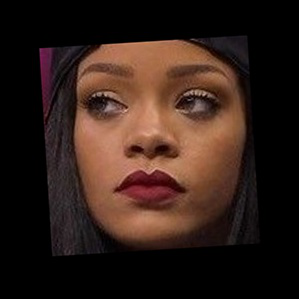

In [ ]:
n = np.random.randint(1, len(df))
img_path = df['imagepath'][n]
print(df['labels'][n])
image1 = tf.keras.preprocessing.image.load_img(img_path)
image1

### Q3: Load the pre-trained model and weights.

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.applications.ResNet50(include_top=True, #Do not include FC layer at the end
                                       input_shape=(224, 224, 3),
                                       weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
len(model.layers)

177

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.output

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
face_model = Model(inputs = model.layers[0].input,outputs = model.layers[-2].output)

In [ ]:
print(len(face_model.layers))

176


In [ ]:
face_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
#face_model = face_model.output

In [ ]:
#face_model = tf.keras.layers.Dense(2048, activation='relu')(face_model)

### Q4: Generate Embedding vectors for each face in the dataset.

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = df['imagepath'][50]
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using face_model model and print the shape
embedding_vector = face_model.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2048,)


In [ ]:
len(df.imagepath)

10770

Create image embeddings for all the images

In [ ]:
embeddings = []
#embeddings = np.zeros((metadata.shape[0], 2622))
for i in range(len(df.imagepath)):
    path = df['imagepath'][i]
    image = load_image(path)
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings.append(face_model.predict(np.expand_dims(image, axis = 0))[0])
    print(i)

In [ ]:
print(embeddings[9080])

[0.         0.         0.00273665 ... 2.020045   0.         0.        ]


In [ ]:
len(embeddings)

10770

In [ ]:
embedding_vector = pd.DataFrame(embeddings)

In [ ]:
print(embedding_vector.shape)

(10770, 2048)


In [ ]:
embedding_vector.to_csv("/content/drive/MyDrive/Colab Notebooks/R10EmbeddingVector.csv")

### Q5:Build distance metrics for identifying the distance between two given images.

In [ ]:
from tensorflow.keras import metrics
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
#finding the euclidean distance between the two image embeddings
def distance(emb1, emb2):
    return np.sqrt(np.sum(np.square(emb1 - emb2)))

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(df['imagepath'][idx1]))
    plt.subplot(122)
    plt.imshow(load_image(df['imagepath'][idx2]))

In [ ]:
def show_pair_cosine(idx1, idx2):
    plt.figure(figsize = (8, 3))
    cosine_similarity = metrics.CosineSimilarity()
    plt.suptitle(f'Similarity = {cosine_similarity(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(df['imagepath'][idx1]))
    plt.subplot(122)
    plt.imshow(load_image(df['imagepath'][idx2]))

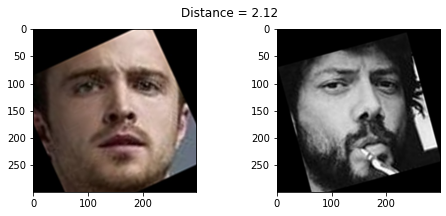

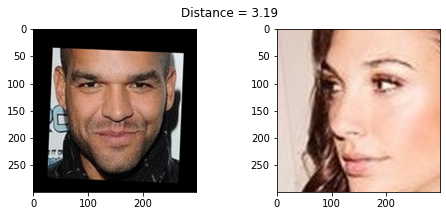

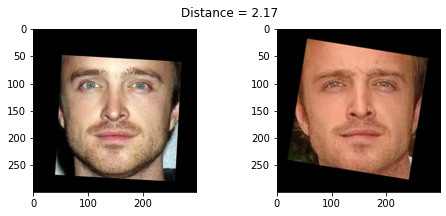

In [ ]:
show_pair(2, 100)
show_pair(376, 8790)
show_pair(30,35)

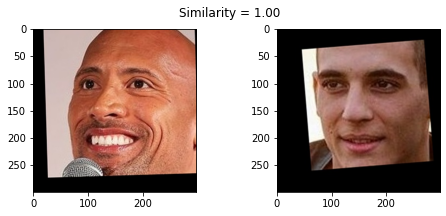

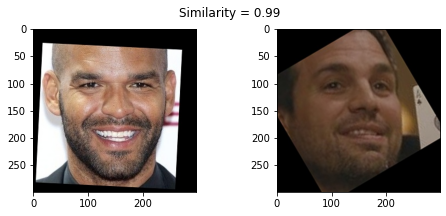

In [ ]:
show_pair_cosine(2000,9767)
show_pair_cosine(357, 3900)

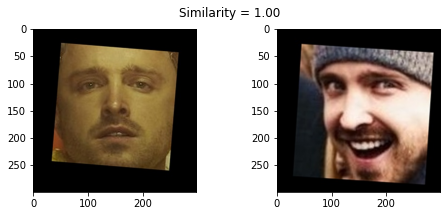

In [ ]:
show_pair_cosine(70, 80)

Conclusion:
As can be the euclidean distance for not simular images is more.
Cosine distance between alike images is close to 1

### Q6:Use PCA for dimensionality reduction.

In [ ]:
print(len(embeddings))

10770


In [ ]:
print(df.shape)

(10770, 2)


In [ ]:
train_idx = np.arange(df.shape[0]) % 9 != 0
test_idx = np.arange(df.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array(df[train_idx].labels)
y_test = np.array(df[test_idx].labels)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2048)

(1197, 2048)

(9573,)

(1197,)

In [ ]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [ ]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
# Covariance matrix
covarianceMatrix = np.cov(X_train_sc.T)

# Eigen values and vector
eigenVals, eigVectors = np.linalg.eig(covarianceMatrix)

# Cumulative variance explained
total = sum(eigenVals)
variance = [(i /total) * 100 for i in sorted(eigenVals, reverse = True)]
cummulativeVariance = np.cumsum(variance)

print('Cumulative Variance Explained', variance)

Cumulative Variance Explained [(13.007600225879745+0j), (7.653186311585261+0j), (4.6076401629628165+0j), (3.0478947792869495+0j), (2.1480762677712164+0j), (1.9538377171412085+0j), (1.7240297874717807+0j), (1.6773900468622052+0j), (1.5485280427479928+0j), (1.3265193369188182+0j), (1.2183292852280894+0j), (1.1947590537854638+0j), (1.1181084235482428+0j), (0.9825099394036594+0j), (0.9426700500869223+0j), (0.9070417822017708+0j), (0.879871852226097+0j), (0.8561913837712616+0j), (0.7968481456903665+0j), (0.7263722378965307+0j), (0.6938324101610842+0j), (0.6834102873105733+0j), (0.6492706634922539+0j), (0.6032191765966693+0j), (0.6019036337331035+0j), (0.5658403580309571+0j), (0.5371905933400278+0j), (0.5237680695693616+0j), (0.5029699080727661+0j), (0.49356341240655366+0j), (0.4812828455201355+0j), (0.4712089279078536+0j), (0.4567227385800488+0j), (0.44955072255586526+0j), (0.42991655069084916+0j), (0.4166544153237172+0j), (0.41006592941936065+0j), (0.39611696747176006+0j), (0.3835626882623

In [ ]:
# Get index where cumulative variance explained is > threshold
threshold = 98
result = list(filter(lambda i: i > threshold, cummulativeVariance))[0]
index = (cummulativeVariance.tolist().index(result))
print(f'Index of element just greater than {threshold}: {str(index)}')

Index of element just greater than 98: 599


In [ ]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = 78, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 599)

(1197, 599)

### Q7: Build an SVM classifier to map each image to its right person

In [ ]:
svc_pca = SVC(C = 1, gamma = 0.03, kernel = 'rbf', class_weight = 'balanced', random_state = 78)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.998


### Q8:Predict using the SVM model.

In [ ]:
X_test_pca.shape

(1197, 599)

In [ ]:
y_test.shape

(1197,)

In [ ]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.043


#### Iteration 2

In [ ]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = 78)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.579


In [ ]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.174


#### Iteration 3

In [ ]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'poly')
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.133


In [ ]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.018


#### Iteration 4

In [ ]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'sigmoid')
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.286


In [ ]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.124


Conclusion:
* SVC is showing very good prediction accuracy when gamma is set to 0.001 & kernel = 'rbf'

# Project 2: Part 2
## DOMAIN: 
State traffic department
## CONTEXT: 
City X’s traffic department wants to understand the traffic density on road during busy hours in order to efficiently program their traffic lights.
## TASK: 
Create an automation using computer vision to impute dynamic bounding boxes to locate cars or vehicles on the road. It would
require for you to do some research on how to impute bounding boxes on video file. You can use video provided with this assignment or any video of your choice which has moving cars to impute bounding boxes.


In [68]:
import cv2
from google.colab.patches import cv2_imshow

In [108]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

In [110]:
# Load names of classes
classesFile = "coco.names";
classes = None
with open(classesFile, 'rt') as f:
  classes = f.read().rstrip('\n').split('\n')

In [111]:
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [71]:
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "/content/drive/MyDrive/Colab Notebooks/yolov3.cfg";
modelWeights = "/content/drive/MyDrive/Colab Notebooks/yolov3.weights";
 
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [72]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

In [116]:
outputFile = "/content/drive/MyDrive/Colab Notebooks/yolo_out_py.avi"
inputFile = '/content/drive/MyDrive/Colab Notebooks/video2.mp4'

cap = cv2.VideoCapture(inputFile)
cap.set(3,640)

False

In [84]:
from google.colab.patches import cv2_imshow

In [75]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [76]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [113]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    label = '%.2f' % conf
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
        print(label)
    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)

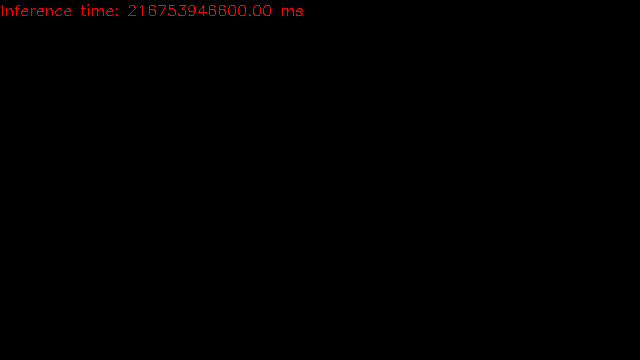

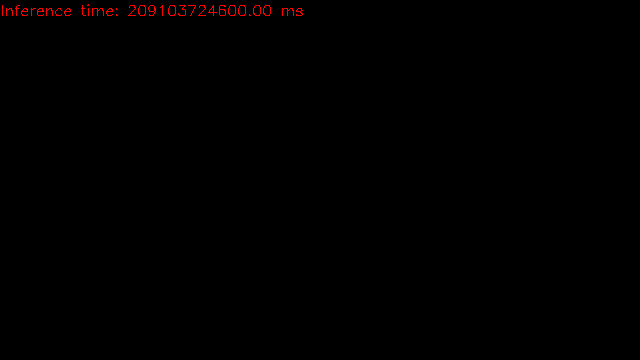

car:0.78


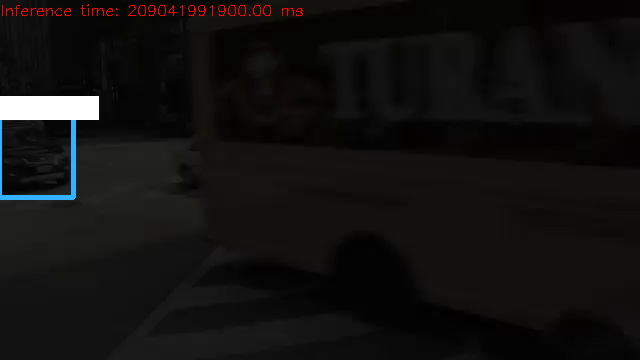

car:0.78


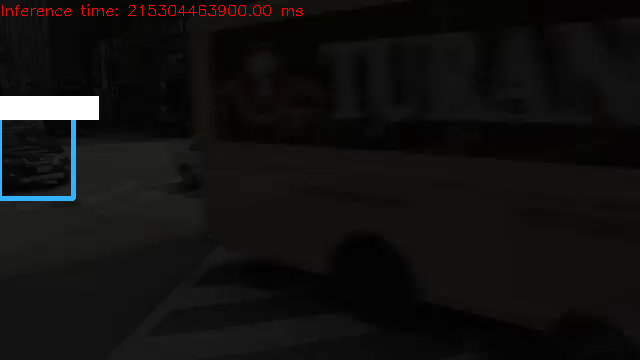

car:0.92
laptop:0.54


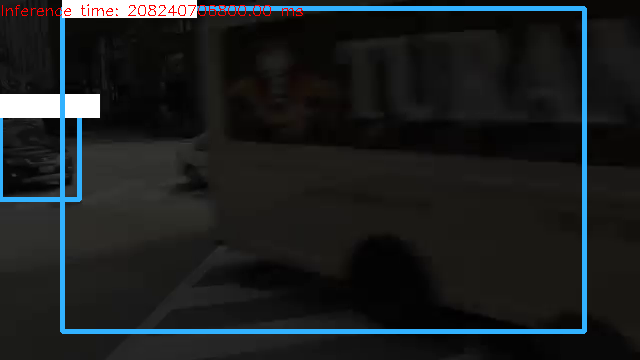

car:0.96
car:0.95
laptop:0.52


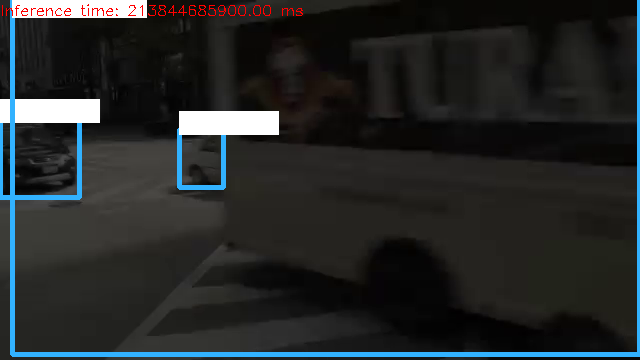

car:0.99
car:0.98


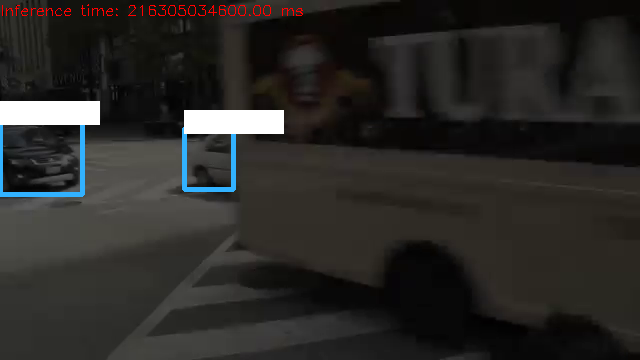

car:0.99
car:0.97


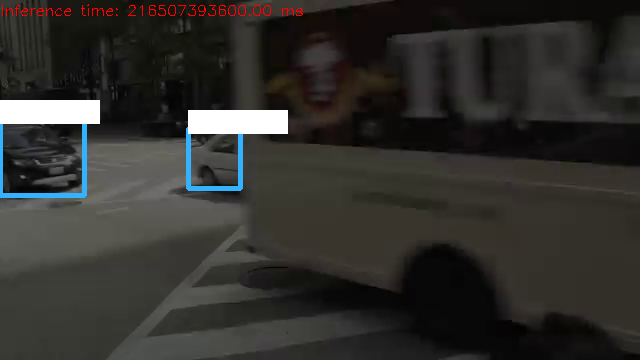

car:0.98
car:0.97
truck:0.80


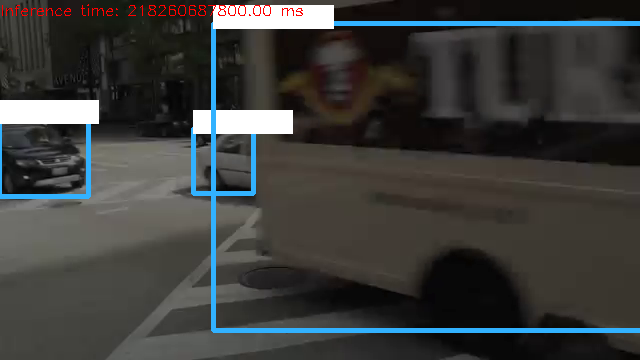

car:0.97
car:0.95
car:0.80
truck:0.63
person:0.51


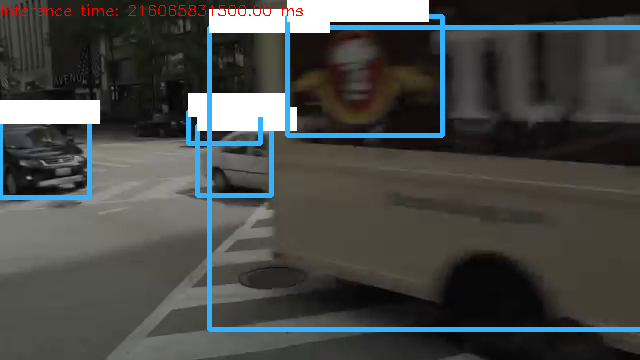

car:0.99
car:0.99
car:0.96
truck:0.81
car:0.53


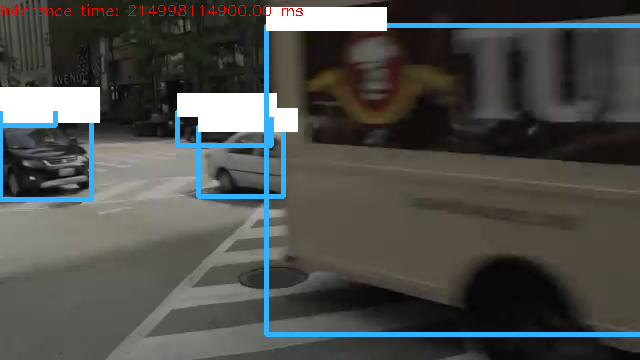

car:0.99
car:0.97
car:0.90
truck:0.85
car:0.76


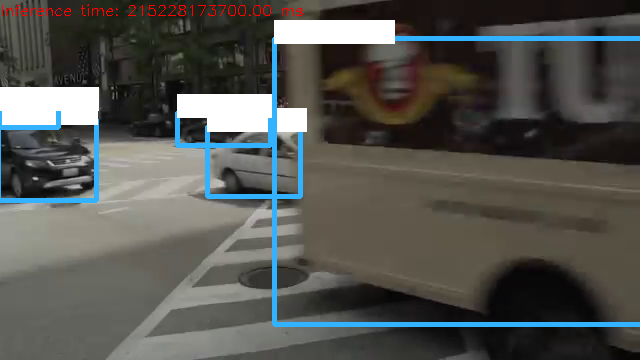

car:0.98
car:0.98
car:0.89
car:0.65
car:0.55


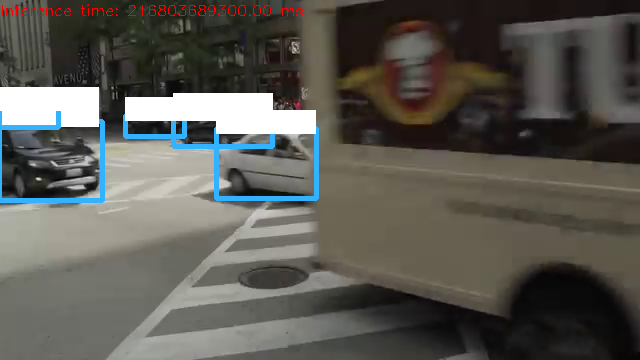

car:0.99
car:0.99
car:0.81
car:0.59


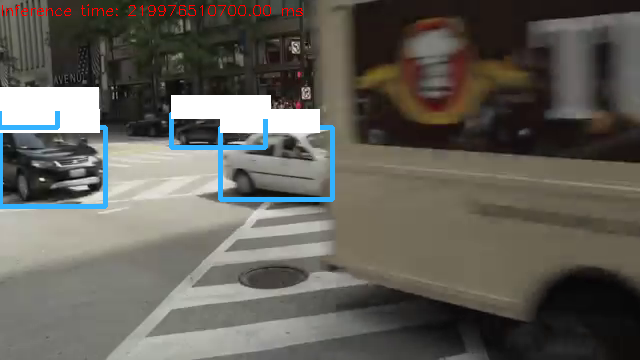

KeyboardInterrupt: ignored

In [117]:
while cv2.waitKey(1) < 0:
  # get frame from the video
    hasFrame, frame = cap.read()
    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")
        print("Output file is stored as ", outputFile)
        cv2.waitKey(3000)
        # Release device
        cap.release()
        break
     # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
    # Sets the input to the network
    net.setInput(blob)
    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))
    # Remove the bounding boxes with low confidence
    postprocess(frame, outs)
    # Put efficiency information. The function getPerfProfile returns the overall time for 
    # inference(t) and the timings for each of the layers(in layersTimes)
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t *100 )#/ cv2.getTickFrequency()*1000000)
    
    cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
    #vid_writer.write(frame.astype(np.uint8))
    cv2_imshow(frame)